## Import Packages

In [30]:
#import packages
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle
import string
import nltk

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

#modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve


import time
import collections
from PIL import Image
import sys

## Get Data

In [2]:
#import key for tmdb API
config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['tmdb.com']['API_KEY']

tmdb.API_KEY = API_KEY

In [3]:
#import data
genome_tags_ids = pd.read_csv('data/genome-tags.csv')
movies = pd.read_csv('data/movies.csv')
genome_tags = pd.read_csv('data/genome-scores.csv')
user_tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

In [4]:
#create movie lookup table
movies = movies.merge(links, left_on = 'movieId', right_on = 'movieId', how = 'left')
movies.dropna(subset=['tmdbId'], inplace=True)
movies['tmdbId'] = movies['tmdbId'].astype(int)
movies.loc[movies['movieId'] == 4207, 'tmdbId'] = 427910
movies.loc[movies['movieId'] == 4568, 'tmdbId'] = 207340
movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357
4,5,Father of the Bride Part II (1995),Comedy,113041,11862


In [5]:
#create genome tag data; 1 record per movie per tag 
genome_tags = genome_tags.merge(genome_tags_ids, left_on = 'tagId', right_on = 'tagId', how = 'left')
genome_tags = genome_tags.merge(movies[['title', 'movieId', 'tmdbId']], left_on = 'movieId', right_on = 'movieId', how = 'left')
genome_tags = genome_tags[genome_tags['tmdbId'].notnull()]
genome_tags['tmdbId'] = genome_tags['tmdbId'].astype(int)
genome_tags.head()

,movieId,tagId,relevance,tag,title,tmdbId
0,1,1,0.02475,007,Toy Story (1995),862
1,1,2,0.02475,007 (series),Toy Story (1995),862
2,1,3,0.04900,18th century,Toy Story (1995),862
3,1,4,0.07750,1920s,Toy Story (1995),862
4,1,5,0.12450,1930s,Toy Story (1995),862


In [6]:
genome_tags['tag'].nunique()

1128

## Clean Movie Tags

Each movie is given a score for each of 1100 tags.  That is too many tags to predict given a dataset of 10000 movies.  Let's concentrate on those tags that are highest scoring.  If we take the top 5 tags for any given movie, that may allow us to narrow our tags set. We can also eliminate tags that are not content related (ie: based on a book, Oscar winner, etc)

Text(0.5,1,'Movies with tag in top 5 list')

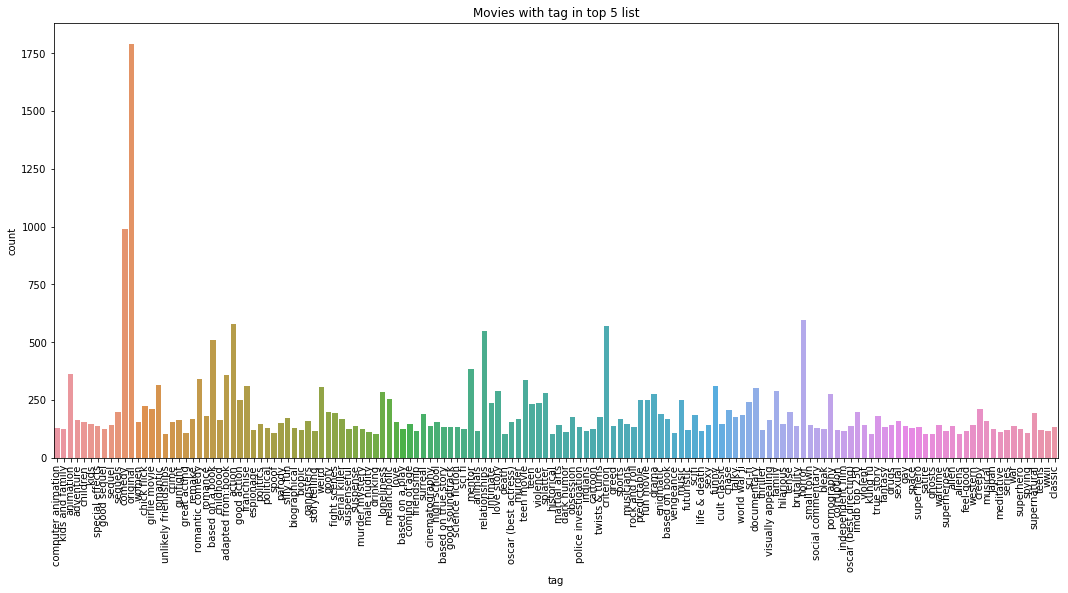

In [7]:
#get top 5 tags per movie
top5 = genome_tags.sort_values(by=['movieId', 'relevance', 'tagId'], ascending = [True, False, True]).groupby('movieId').head(5)
top5.head()

#Get list of top 5 tags
tagslist = top5.tag.value_counts()
tagslist = tagslist[tagslist > 100]
tagslist = list(tagslist.index.values)  

top5 = top5.loc[top5['tag'].isin(tagslist)]

fig, ax = plt.subplots(figsize=(18,8))
ax = sns.countplot(x = "tag", data = top5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Movies with tag in top 5 list")

In [8]:
#keep tags that are in top5 for any movie
genome_tags = genome_tags.loc[genome_tags['tag'].isin(tagslist)]
genome_tags = genome_tags.pivot(index='movieId', columns='tag', values='relevance')
genome_tags.columns = map(str.lower, genome_tags.columns)
genome_tags.columns = genome_tags.columns.str.replace(' ', '_')

#drop tags that should not be predicted based on picture
genome_tags.columns.values

drop_cols = ['adapted_from:book',
             'based_on_a_book', 
             'based_on_a_play',
             'based_on_book', 
             'based_on_true_story', 
             'cinematography', 
             'classic',
             'computer_animation',
             'criterion', 
             'cult_classic',
             'franchise', 
             'good_sequel', 
             'good_soundtrack',
             'great_acting',
             'imdb_top_250', 
             'male_nudity', 
             'original',
             'oscar_(best_actress)', 
             'oscar_(best_directing)', 
             'parody',
             'predictable', 
             'remake',
             'sequel', 
             'sequels',
             'series',
             'special_effects',
             'storytelling']
genome_tags.drop(columns = drop_cols, inplace = True)

In [9]:
#examine genome tag data
genome_tags.head()

,action,adventure,alien,aliens,animals,animation,biographical,biopic,bleak,brutality,...,violence,violent,visually_appealing,war,wartime,weird,western,women,world_war_ii,wwii
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.65025,0.89800,0.13850,0.25350,0.69200,0.98650,0.11625,0.09975,0.11750,0.24150,...,0.28350,0.19600,0.40675,0.06375,0.09200,0.32300,0.02275,0.10850,0.04300,0.03600
2,0.62825,0.97975,0.03725,0.05575,0.91150,0.13725,0.08475,0.05375,0.04975,0.23100,...,0.17100,0.13450,0.18850,0.04175,0.04625,0.30275,0.01275,0.12750,0.01650,0.01325
3,0.15575,0.42900,0.03100,0.04250,0.09125,0.02650,0.04350,0.03450,0.06850,0.29825,...,0.11575,0.10175,0.21950,0.03675,0.06600,0.17125,0.03500,0.37375,0.02650,0.01725
4,0.13825,0.12975,0.02375,0.02975,0.13075,0.04450,0.03150,0.03175,0.05075,0.31475,...,0.17225,0.09125,0.18425,0.03250,0.05425,0.16725,0.03000,0.97575,0.02150,0.01325
5,0.15475,0.15250,0.03225,0.03500,0.12850,0.02675,0.05625,0.03800,0.06125,0.26600,...,0.10500,0.08375,0.19375,0.03400,0.05700,0.25750,0.02400,0.46200,0.01875,0.01325


In [10]:
genome_tags.shape[1]

121

## Tag Clustering

121 Tags are still too many, so let's cluster similar tags together.  Use correlation matrix to cluster similar tags together.  Identify and name clusters to result in 45 tags. Use the max value of tags to get score per tag cluster and turn tag scores into a binary yes/no variable based on arbitrary cut-off (0.75) 

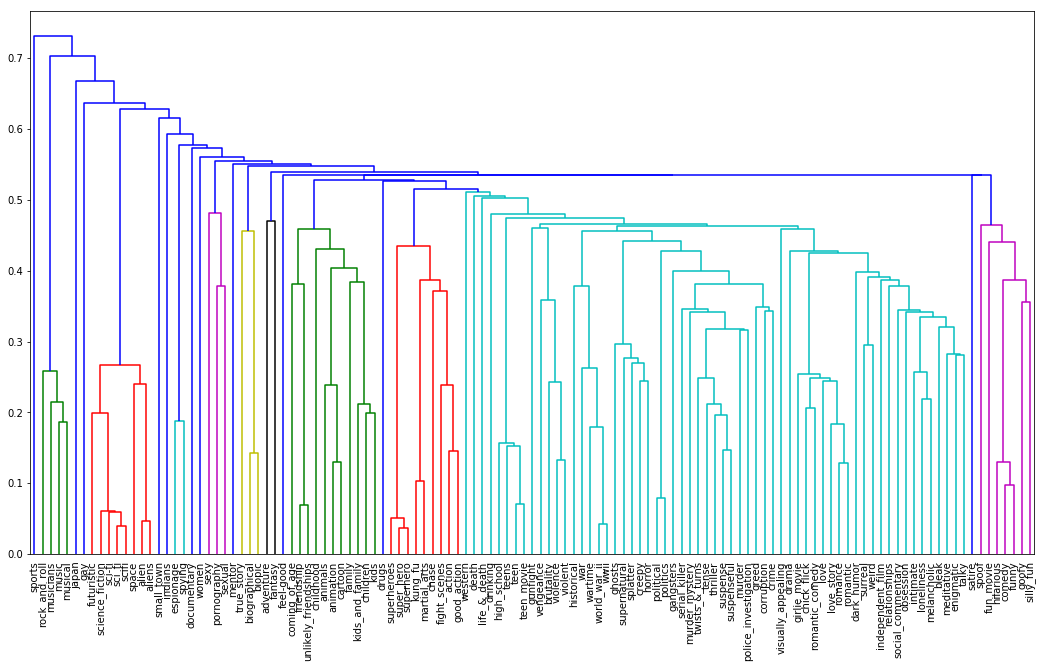

In [11]:
#get correlation matrix for each tag
corr = genome_tags.corr()

#change to distance matrix using 
corr = 1- corr
corr.head()

cond_dist = squareform(corr)

Z = linkage(cond_dist)
fig, ax = plt.subplots(figsize=(18, 10))
g = dendrogram(Z, ax = ax, labels=corr.index)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
plt.show()

In [12]:
#set cut point at 0.4
cutree = cut_tree(Z, height = 0.40)
cutree = np.reshape(cutree, -1)

#name tag clusters
var_clusters = pd.DataFrame({'tag' : corr.index,
                            'cluster': cutree})
var_clusters.sort_values(by = 'cluster')
cluster_tags = {
    0: 'action',
    1: 'adventure',
    2: 'scifi',
    3: 'animation',
    4: 'biopic',
    5: 'melancholic_wierd',
    6: 'violent',
    7: 'romance',
    8: 'childhood', 
    9: 'family',
    10: 'comedy', 
    11: 'friendships', 
    12: 'crime',
    13: 'horror', 
    14: 'death', 
    15: 'documentary', 
    16: 'drama', 
    17: 'drugs', 
    18: 'drinking',
    19: 'spy',
    20: 'fantasy', 
    21: 'feel_good',
    22: 'fun', 
    23: 'gangsters', 
    24: 'gay',
    25: 'gunfight',
    26: 'teen', 
    27: 'war',
    28: 'indians', 
    29: 'japan', 
    30: 'life_death',
    31: 'mentor', 
    32: 'music', 
    33: 'political', 
    34: 'sexual', 
    35: 'satire', 
    36: 'sexy', 
    37: 'smalltown', 
    38: 'spoof', 
    39: 'sports', 
    40: 'superhero', 
    41: 'true story', 
    42: 'visual',
    43: 'western',
    44: 'women'
}

topics = list(cluster_tags.values())

In [13]:
#reduce tags to max value per cluster
genome_tags = pd.melt(genome_tags.reset_index(), id_vars = 'movieId', var_name='tag', value_name='relevance')
genome_tags = genome_tags.merge(var_clusters, left_on = 'tag', right_on = 'tag', how = "left")
genome_tags = pd.DataFrame(genome_tags.groupby(['movieId', 'cluster'])['relevance'].max()).reset_index()
genome_tags['cluster_label'] = genome_tags.cluster.map(cluster_tags)
genome_tags = genome_tags.pivot(index='movieId', columns='cluster_label', values='relevance')

In [14]:
#create master tags dataset with title and linking IDs
genome_tags = genome_tags.merge(movies[['title', 'tmdbId', 'movieId']] , left_index = True, right_on = 'movieId', how = 'left')

In [15]:
#make genome tags binary; anything with score > 0.75 is true
genome_tags_binary = genome_tags.drop(['title', 'tmdbId', 'movieId'], axis = 1) > 0.75
genome_tags_binary = (genome_tags_binary*1).apply(pd.to_numeric)
genome_tags_binary[['movieId', 'title', 'tmdbId']] = genome_tags[['movieId','title', 'tmdbId']]
genome_tags_binary.head()

,action,adventure,animation,biopic,childhood,comedy,crime,death,documentary,drama,...,teen,true story,violent,visual,war,western,women,movieId,title,tmdbId
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Toy Story (1995),862
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,Jumanji (1995),8844
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,Grumpier Old Men (1995),15602
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,Waiting to Exhale (1995),31357
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,Father of the Bride Part II (1995),11862


In [16]:
#review movies per tag
genome_tags_binary[topics].sum(axis = 0).sort_values(ascending = False)

melancholic_wierd    3641
crime                2260
comedy               1605
action               1535
violent              1265
romance              1235
mentor               1228
drama                1072
horror               1037
visual                843
family                822
scifi                 706
war                   643
sexual                638
fun                   627
friendships           624
teen                  617
animation             578
childhood             548
music                 494
adventure             425
documentary           383
true story            360
feel_good             357
political             355
gunfight              344
life_death            319
biopic                312
gangsters             297
sexy                  293
fantasy               290
drugs                 275
death                 260
women                 255
spy                   246
smalltown             233
drinking              230
satire                219
superhero   

## Get Movie Overviews

Use tmdb API to get movie overviews for each tagged movie. This can take some time so save result to use for later.

In [17]:
'''
overviews = collections.defaultdict(dict)

movie_list = genome_tags[['movieId', 'title', 'tmdbId']]

for i in movie_list['tmdbId']:
    try:
        #api call to get movie poster path
        movie = tmdb.Movies(i)
        movie.info()
    
    except requests.exceptions.HTTPError:
        print("tmbdId %s doesn't exist" %i)
        overviews[i]['tmdbId_exist'] = 0
        continue
    
    else:
        overviews[i]['tmdbId_exist'] = 1
        overviews[i]['overview'] = movie.info()['overview']
        overviews[i]['title'] = movie.info()['title']
        time.sleep(.5)

overviews_df = pd.DataFrame.from_dict(overviews, orient = 'index')


#pickle movie overviews
with open('overviews_df.pickle', 'wb') as handle:
    pickle.dump(overviews_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''

'\noverviews = collections.defaultdict(dict)\n\nmovie_list = genome_tags[[\'movieId\', \'title\', \'tmdbId\']]\n\nfor i in movie_list[\'tmdbId\']:\n    try:\n        #api call to get movie poster path\n        movie = tmdb.Movies(i)\n        movie.info()\n    \n    except requests.exceptions.HTTPError:\n        print("tmbdId %s doesn\'t exist" %i)\n        overviews[i][\'tmdbId_exist\'] = 0\n        continue\n    \n    else:\n        overviews[i][\'tmdbId_exist\'] = 1\n        overviews[i][\'overview\'] = movie.info()[\'overview\']\n        overviews[i][\'title\'] = movie.info()[\'title\']\n        time.sleep(.5)\n\noverviews_df = pd.DataFrame.from_dict(overviews, orient = \'index\')\n\n\n#pickle movie overviews\nwith open(\'overviews_df.pickle\', \'wb\') as handle:\n    pickle.dump(overviews_df, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n'

## Create final dataset

Final dataset should be a list of 10000 movies, 49 binary flags for each of the tag clusters, and the text overview

In [18]:
#Merge number of competitors to listings data
with open('overviews_df.pickle', 'rb') as handle:
    overviews_df = pickle.load(handle)

In [19]:
overviews_df.head()

,tmdbId_exist,overview,title
2,1,Taisto Kasurinen is a Finnish coal miner whose...,Ariel
5,1,It's Ted the Bellhop's first night on the job....,Four Rooms
6,1,"While racing to a boxing match, Frank, Mike, J...",Judgment Night
11,1,Princess Leia is captured and held hostage by ...,Star Wars
12,1,"Nemo, an adventurous young clownfish, is unexp...",Finding Nemo


In [20]:
print('Overview for Toy Story')
overviews_df['overview'][862]

Overview for Toy Story


"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [21]:
overviews_df = overviews_df.reset_index().rename(columns={'index':'tmdbId'})
overviews_df.overview=overviews_df.overview.astype(str)
final= pd.merge(overviews_df, genome_tags_binary, left_on = 'tmdbId', right_on = 'tmdbId')

In [22]:
#remove those with null overviews
final = final[final['overview'] != 'nan']

In [23]:
len(final)

10907

In [24]:
final.head()

,tmdbId,tmdbId_exist,overview,title_x,action,adventure,animation,biopic,childhood,comedy,...,superhero,teen,true story,violent,visual,war,western,women,movieId,title_y
0,2,1,Taisto Kasurinen is a Finnish coal miner whose...,Ariel,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4470,Ariel (1988)
1,5,1,It's Ted the Bellhop's first night on the job....,Four Rooms,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18,Four Rooms (1995)
2,6,1,"While racing to a boxing match, Frank, Mike, J...",Judgment Night,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,479,Judgment Night (1993)
3,11,1,Princess Leia is captured and held hostage by ...,Star Wars,1,1,0,0,1,0,...,0,0,0,0,1,1,0,0,260,Star Wars: Episode IV - A New Hope (1977)
4,12,1,"Nemo, an adventurous young clownfish, is unexp...",Finding Nemo,0,1,1,0,1,1,...,0,0,0,0,1,0,0,0,6377,Finding Nemo (2003)


## Modeling

Split dataset into training and test sets.  Use one tag as outcome for now.  

Feature set should be Tf-IDF matrix of overview text with stop words removed and lemmitization applied.  Try with vocabulary of 800 terms (~10% of training instances)

In [25]:
train_set, test_set= train_test_split(final, test_size = 0.33)

train_1 = train_set[train_set['comedy'] == 1]
train_0 = train_set[train_set['comedy'] == 0]
train_0 = train_0.sample(n = len(train_1)*4)

train_set = pd.concat([train_1, train_0])

X_train = train_set['overview']
y_train = train_set['comedy']
X_test = test_set['overview']
y_test = test_set['comedy']

n_features = len(train_set)/10

In [26]:
X_train, X_test, y_train, y_test = train_test_split(final['overview'], final['action'], test_size = 0.33, random_state = 412)

In [27]:
len(X_train)

7307

In [28]:
X_train.nunique()

7302

In [31]:
#Create a list of classifiers to test
clfs = []
clfs.append(SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120))
clfs.append(KNeighborsClassifier())
clfs.append(RandomForestClassifier())
clfs.append(SVC())
clfs.append(MultinomialNB())

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemming(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems


pipeline = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , stop_words='english', max_features = 700)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])



#Run through the pipeline for each classifier in the list
#Can take awhile to run
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, scoring = 'accuracy', return_train_score = False, cv = 5)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=120, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  7.719654178619384
fit_time  std  0.16703602800977488
score_time  mean  1.879312515258789
score_time  std  0.07901877503397267
test_score  mean  0.8743679258340679
test_score  std  0.003951122890628534
---------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
-----------------------------------
fit_time  mean  7.9688928604125975
fit_time  std  0.13620235229699712
score_time  mean  2.2493283271789553
score_time  std  0.07938552227466265
test_s

Classifiers perform similarly so try hyperparameter tuning with Logistic Regression

In [124]:
pipeline.set_params(clf = (SGDClassifier(loss = 'log', penalty = 'elasticnet', max_iter = 120)))

param_grid = {
    'vect__max_df': [0.7, 0.6, 0.5],
    'vect__min_df': [0.01, 0.05, 0.1],
    'clf__l1_ratio' :  np.linspace(0.1,1,5),
}

cv_grid = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'accuracy', cv = 5, verbose = 1)

In [125]:
model = cv_grid.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 62.6min finished


In [126]:
print('Parameters:', model.best_params_)
print('Best Score:', model.best_score_)

Parameters: {'clf__l1_ratio': 0.775, 'vect__max_df': 0.7, 'vect__min_df': 0.01}
Best Score: 0.8710825236074996


In [127]:
model.predict(X_test).sum()

139

In [128]:
print('positive class', y_test.sum())
print('positive prevalance', y_test.sum()/len(y_test))

positive class 512
positive prevalance 0.14222222222222222


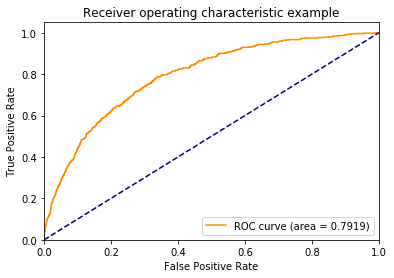

Confusion Matrix: 
 [[3026   62]
 [ 435   77]]
Accuracy: 86.194%
Recall: 15.039%
Precision: 55.396%


In [129]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

y_predict = model.predict(X_test)
accuracy = accuracy_score(y_test,y_predict)
recall = recall_score(y_test,y_predict)
precision = precision_score(y_test,y_predict)

print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict))
print('Accuracy: %.3f%%' % (accuracy*100))
print('Recall: %.3f%%' % (recall*100))
print('Precision: %.3f%%' % (precision*100))

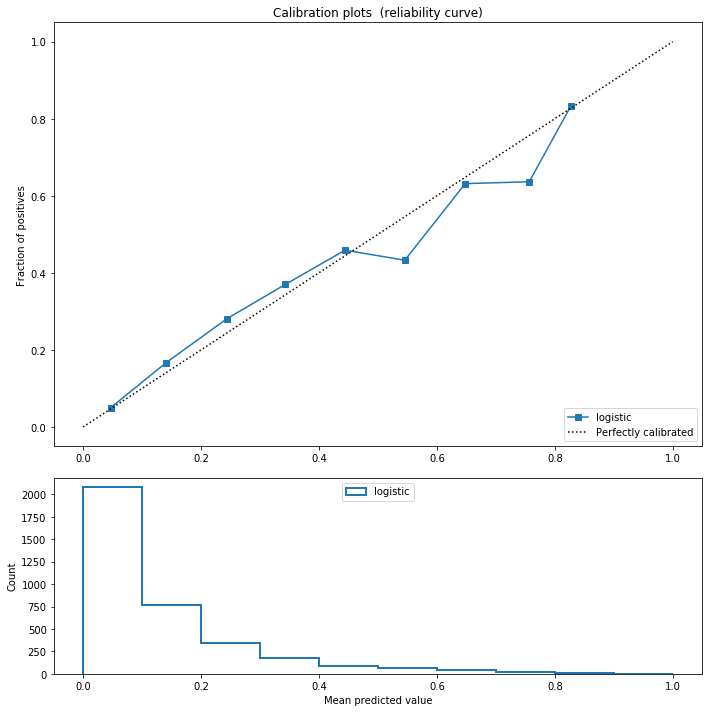

In [130]:
#Calibration Plot
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_score, n_bins=10)

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='logistic')
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax2.hist(y_score, range=(0, 1), bins=10, label='logistic', histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()

## Scratch Pad

In [131]:
#Get feature importances by getting coef per each feature
features = model.best_estimator_.named_steps['vect'].get_feature_names()

coefficients = model.best_estimator_.named_steps['clf'].coef_
coefficients = np.squeeze(coefficients)
coefficients = pd.DataFrame(
    {'features': features,
     'coefficients': coefficients
    })

coefficients.set_index('features', inplace = True)
coefficients['abs'] = abs(coefficients['coefficients'])
coeffcients = coefficients.sort_values(by= ['abs'], ascending = False, inplace = True)
coefficients['coefficients'][:30]

features
assassin       4.368256
cop            3.528429
agent          3.166229
art            3.154215
live          -2.943349
enemi          2.915718
tale          -2.819943
russian        2.557011
lover         -2.548750
master         2.523193
–              2.464364
danger         2.441276
stop           2.417624
mother        -2.415376
deadli         2.386046
govern         2.326520
writer        -2.318218
colleg        -2.302036
kill           2.258168
fight          2.252207
anim          -2.219574
militari       2.176021
documentari   -2.125935
film          -2.112333
u.s.           2.072357
explor        -2.051141
oper           2.047265
led            2.003399
train          1.995920
act           -1.989858
Name: coefficients, dtype: float64

In [132]:
action_pred = model.predict(X_test)

In [133]:
X_test[(action_pred == 0) & (y_test == 1)]

4210     Seibei Iguchi leads a difficult life as a low ...
10818    A crime drama set in 1970s Boston, about a gun...
1858     When a train carrying atomic warheads mysterio...
8742     John Carter is a war-weary, former military ca...
1044     In AD 922, Arab courtier, Ahmad Ibn Fadlan acc...
5366     In Nazi-occupied France during World War II, a...
4066     Alice hires a professional negotiator to obtai...
687      Veteran buttoned-down LAPD detective Roger Mur...
10784    Deboot of the Power Rangers. Joseph Kahn's tak...
5891     In the year 2019, a plague has transformed alm...
10212    The story of a super-secret spy organization t...
5093     Philo Beddoe is your regular, easygoing, truck...
3456     Miles Logan is a jewel thief who just hit the ...
2632     Upon learning that he has to come out of retir...
536      A man is accidentally transported to 1300 A.D....
2545     Tough guy Thomas Beckett is an US soldier work...
10373    Ex-hitman John Wick comes out of retirement to.

In [154]:
pipeline2 = Pipeline([('vect', CountVectorizer(tokenizer=tokenize , 
                                               stop_words='english', 
                                               max_features = 700, 
                                               max_df = 0.7, min_df = 0.01)),
                      ('tfidf', TfidfTransformer()),
])
pipeline2.fit(X_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=700, min_df=0.01,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
      ...y=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [155]:
output = pipeline2.transform(X_test)

In [157]:
output = pd.DataFrame(output.toarray())
output['truth'] = y_test.reset_index(drop=True)
output['pred'] = action_pred

In [168]:
coefficients = model.best_estimator_.named_steps['clf'].coef_
coefficients = np.squeeze(coefficients)

In [170]:
#what words are most associated with true positives?
tp_features_sum = (pd.DataFrame(output.loc[(output['truth'] == 1) & (output['pred'] == 1), ].mean(axis = 0))
                                .drop(['truth', 'pred']))

tp_features_sum['features'] = features
tp_features_sum['coefficients'] = coefficients
tp_features_sum.sort_values(by = 0, ascending = False, inplace = True)
tp_features_sum.head(20)

,0,features,coefficients
211,0.101004,hi,1.323710
30,0.075108,assassin,4.368256
13,0.065606,agent,3.166229
182,0.049110,forc,1.608891
2,0.041660,'s,-0.383068
481,0.040900,world,0.622549
178,0.039202,fight,2.252207
487,0.038250,–,2.464364
289,0.037610,mission,1.172616
27,0.035102,art,3.154215


In [171]:
#what words are most associated with false negatives?
fn_features_sum = (pd.DataFrame(output.loc[(output['truth'] == 1) & (output['pred'] == 0), ].mean(axis = 0))
                                .drop(['truth', 'pred']))

fn_features_sum['features'] = features
fn_features_sum['coefficients'] = coefficients
fn_features_sum.sort_values(by = 0, ascending = False, inplace = True)
fn_features_sum.head(20)

,0,features,coefficients
211,0.089877,hi,1.323710
2,0.060016,'s,-0.383068
203,0.028062,ha,0.617735
275,0.027679,man,0.000000
182,0.024855,forc,1.608891
301,0.024597,new,0.326748
481,0.023980,world,0.622549
293,0.022165,murder,0.301941
178,0.021873,fight,2.252207
428,0.021569,team,1.322660


In [177]:
for i in np.squeeze(np.nonzero(output.loc[(output['truth'] == 1) & (output['pred'] == 0),0])):
    print(features[i])

``
agent
apart
appear
attract
black
caus
chanc
close
connect
creatur
dark
discov
doe
earli
entir
far
form
game
gener
includ
land
london
lost
mani
marri
member
n't
oper
parent
pari
receiv
recent
run
sent
sister
steal
street
suspect
teen


In [66]:
for i in np.nonzero(output.iloc[0, :-2])[0]:
    print(features[i])

act
doe
dure
expect
fight
gener
hope
order
prison
themselv
use
war


In [67]:
X_test.iloc[0]

'During the Boer War, three Australian lieutenants are on trial for shooting Boer prisoners. Though they acted under orders, they are being used as scapegoats by the General Staff, who hopes to distance themselves from the irregular practices of the war. The trial does not progress as smoothly as expected by the General Staff, as the defence puts up a strong fight in the courtroom.'

In [172]:
for i in np.nonzero(output.loc[0])[1]:
    print(features[i])

thi
soon
seemingli
planet
like
lie
island
hope
hi
exist
everyth
discov
``
.
,
''


In [152]:
features[16]
#, 705, 694, 693, 645, 635, 610, 530, 497, 491, 409, 407, 393,
#       363, 362, 349, 335, 329, 297, 232, 193, 103,  66,  24,   2]

'``'

In [174]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [169]:
X_test.iloc

"The bold Tira works as dancing beauty and lion tamer at a fair. Out of an urgent need of money, she agrees to a risky new number: she'll put her head into a lion's muzzle! With this attraction the circus makes it to New York and Tira can persue her dearest occupation: flirting with rich men and accepting expensive presents."

In [159]:
overviews_df.loc[915]

tmdbId                                                       1635
tmdbId_exist                                                    1
overview        In 2019, Lincoln Six-Echo is a resident of a s...
title                                                  The Island
Name: 915, dtype: object

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(stop_words = 'english')#, max_features = 800, analyzer = stemming)
x = v.fit_transform(X_train)

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    '''Top tfidf features in specific document (matrix row)'''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
top_feats_in_doc(x, v.get_feature_names(), 1)

In [102]:
features_2 = v.get_feature_names()

In [107]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}
stemmer = PorterStemmer()


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(X_train)
    stems = stem_tokens(tokens, stemmer)
    return stems

#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())


True